**Оптимизация управления персоналом компании «Работа с заботой»**

**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. 


Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 



**Задачи**

- Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика;
- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Для выполнения первой задачи потребуется:

- изучить общую информацию о данных;
- произвести предобработку данных;
- выполнить исследовательский анализ данных;
- подготовить признаки в пайплайне;
- обучить модели;

Для этой задачи заказчик предоставил данные с признаками:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Тренировочная выборка: train_job_satisfaction_rate.csv


Входные признаки тестовой выборки: test_features.csv


Целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv


Для выполнения второй задачи потребуется:

- изучить общую информацию о данных;
- произвести предобработку данных;
- выполнить исследовательский анализ данных;
- добавить новый входной признак;
- подготовить признаки в пайплайне;
- обучить модели;


Для второй задачи используются данные с признаками:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- quit — увольнение сотрудника из компании, целевой признак.


Тренировочная выборка: train_quit.csv


Входные признаки тестовой выборки те же, что и в прошлой задаче:  test_features.csv


Целевой признак тестовой выборки: test_target_quit.csv

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install imbalanced-learn -q
!pip install shap -q

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


RANDOM_STATE = 42
TEST_SIZE = 0.25

## Задача №1 (предсказание уровня удовлетворённости сотрудника)

### Шаг 1. Загрузка данных

##### Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним его в датафрейм

In [2]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

##### Изучим информацию о датафреймах

In [3]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [5]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [7]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Типы данных соответствуют действительности, есть пропуски в train_job_satisfaction_rate(в `dept` и в `level`) и test_features(в `dept` и в `level`)**

### Шаг 2. Предобработка данных.

##### Проверим на наличие пропусков и дубликатов

In [9]:
def skips_dulicates(data):
    total_missing = data.isna().sum().sum()
    if total_missing > 0:
        print(f"Пропуски найдены, общее количество пропусков: {total_missing}")
        print("Пропуски по столбцам:")
        print(data.isna().sum())
    else:
        print("Пропусков нет.")
    duplicate_count = data.duplicated().sum()
    if duplicate_count > 0:
        print(f"Количество явных дубликатов: {duplicate_count}")
    else:
        print("Дубликатов нет.")
    return data

In [10]:
def unique_values(data):
    unique_dict = {}  
    for column in data.columns:
        if data[column].dtype == 'object':
            unique_dict[column] = data[column].unique() 
    return unique_dict

In [11]:
skips_dulicates(train_job_satisfaction_rate);

Пропуски найдены, общее количество пропусков: 10
Пропуски по столбцам:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Дубликатов нет.


In [12]:
skips_dulicates(test_features);

Пропуски найдены, общее количество пропусков: 3
Пропуски по столбцам:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
Дубликатов нет.


In [13]:
skips_dulicates(test_target_job_satisfaction_rate);

Пропусков нет.
Дубликатов нет.


Явныйх дубликтов обнаружено не было, проверим неявные.

In [14]:
unique_values(train_job_satisfaction_rate)

{'dept': array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
       dtype=object),
 'level': array(['junior', 'middle', 'sinior', nan], dtype=object),
 'workload': array(['medium', 'high', 'low'], dtype=object),
 'last_year_promo': array(['no', 'yes'], dtype=object),
 'last_year_violations': array(['no', 'yes'], dtype=object)}

Есть орфографическая ошибка, заменим sinior на senior.

In [15]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace({'sinior': 'senior'})

In [16]:
unique_values(test_features)

{'dept': array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
       dtype=object),
 'level': array(['junior', 'middle', 'sinior', nan], dtype=object),
 'workload': array(['medium', 'low', 'high', ' '], dtype=object),
 'last_year_promo': array(['no', 'yes'], dtype=object),
 'last_year_violations': array(['no', 'yes'], dtype=object)}

In [17]:
test_features['level'] = test_features['level'].replace({'sinior': 'senior'})

In [18]:
test_features[test_features['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [19]:
test_features[test_features['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [20]:
test_features['dept'] = test_features['dept'].replace({' ': np.nan})
test_features['workload'] = test_features['workload'].replace({' ': np.nan})

In [21]:
test_target_job_satisfaction_rate['job_satisfaction_rate'].unique()

array([0.74, 0.75, 0.6 , 0.72, 0.08, 0.76, 0.64, 0.38, 0.14, 0.59, 0.91,
       0.78, 0.7 , 0.79, 0.34, 0.81, 0.23, 0.4 , 0.58, 0.77, 0.68, 0.24,
       0.42, 0.69, 0.47, 0.35, 0.71, 0.83, 0.61, 0.65, 0.37, 0.45, 0.63,
       0.82, 0.16, 0.89, 0.28, 0.32, 0.88, 0.36, 0.33, 0.31, 0.27, 0.73,
       0.53, 0.26, 0.57, 0.2 , 1.  , 0.56, 0.67, 0.19, 0.52, 0.43, 0.12,
       0.11, 0.21, 0.13, 0.49, 0.22, 0.86, 0.46, 0.41, 0.48, 0.29, 0.87,
       0.66, 0.8 , 0.55, 0.5 , 0.51, 0.62, 0.85, 0.84, 0.15, 0.39, 0.25,
       0.9 , 0.07, 0.1 , 0.92, 0.3 , 0.44, 0.18, 0.93, 0.54, 0.96, 0.09,
       0.99, 0.17, 0.95, 0.06, 0.94, 0.03, 0.98, 0.97, 0.04, 0.05])

### Шаг 3. Исследовательский анализ данных

In [24]:
def num_variable_analysis(data, column, title):
    print(data[column].describe())
    fig, ax = plt.subplots(figsize = (17,2))
    ax = data[[column]].boxplot(vert = False, ax =ax)
    ax.set_title(f'Диаграмма размаха {title}')
    plt.show()

In [25]:
def num_variable_visualization(data, column, title, x_title):
    unique_values = data[column].nunique()
    is_discrete = unique_values <= 20 and (data[column].dtype == 'int64' and (data[column] % 1 == 0).all())

    if is_discrete:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=column, data=data, palette='pastel', edgecolor='black')
        plt.title(title)
        plt.xlabel(x_title)
        plt.ylabel('Количество')
    else:
        data = data[column].plot(title=title, kind='hist', bins=25, grid=True, 
                                             figsize=(10,6), color='skyblue', edgecolor='black')
        data.set_xlabel(x_title)
        data.set_ylabel('Количество клиентов')
    plt.show()

In [26]:
def cat_variable_visualization(data, column, title, ax):
    value_counts = data[column].value_counts()
    labels = value_counts.index
    sizes = value_counts.values

    ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.tab20.colors,
        wedgeprops={'edgecolor': 'black'}
    )
    ax.set_title(title, fontsize=14)

##### Изучим количественные признаки train_job_satisfaction_rate

В train_job_satisfaction_rate количественными признакими являются:

- employment_years;
- supervisor_evaluation;
- salary;
- job_satisfaction_rate.

In [27]:
train_job_satisfaction_rate['employment_years'].unique()

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5])

Данный признак является дискретным. Для него не нужно строить ящики с усами, так как признак имеет, скорее, распределение категориального признака, пусть и представленного уже в численном виде.

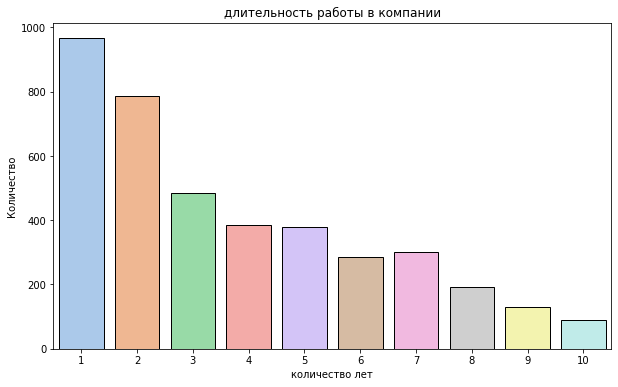

In [28]:
num_variable_visualization(train_job_satisfaction_rate, 'employment_years', 'длительность работы в компании', 'количество лет')

Наибольшее количестов сотрудников работает 1 год в компании, опытных сотрудников намного меньше, наблюдается дисбаланс классов.

In [29]:
train_job_satisfaction_rate['supervisor_evaluation'].unique()

array([1, 5, 2, 3, 4])

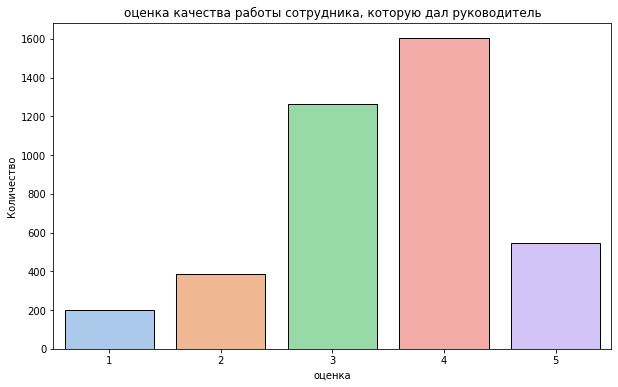

In [30]:
num_variable_visualization(train_job_satisfaction_rate, 'supervisor_evaluation', 'оценка качества работы сотрудника, которую дал руководитель', 'оценка')

В основном преобладают оценки 3 и 4. 

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


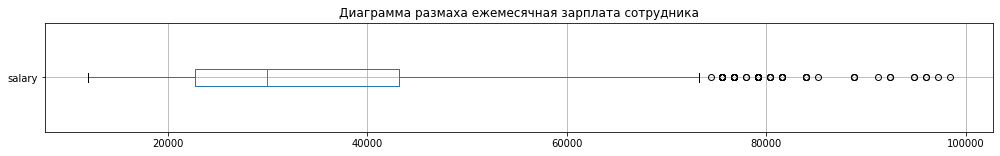

In [31]:
num_variable_analysis(train_job_satisfaction_rate, 'salary', 'ежемесячная зарплата сотрудника')

Наблюдаются выбросы, но не будем их удалять, так как они вполне могут быть реальными (сотрудники занимающие высокие должности).

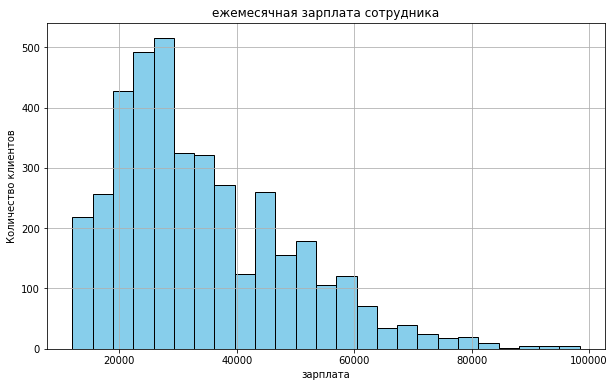

In [32]:
num_variable_visualization(train_job_satisfaction_rate, 'salary', 'ежемесячная зарплата сотрудника', 'зарплата')

Гистограмма смещена влево, присутствует значительный разброс, в дальнейшем потребуется применить масштабирование.

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


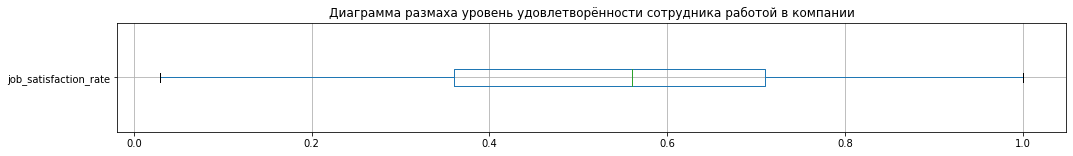

In [33]:
num_variable_analysis(train_job_satisfaction_rate, 'job_satisfaction_rate', 'уровень удовлетворённости сотрудника работой в компании')

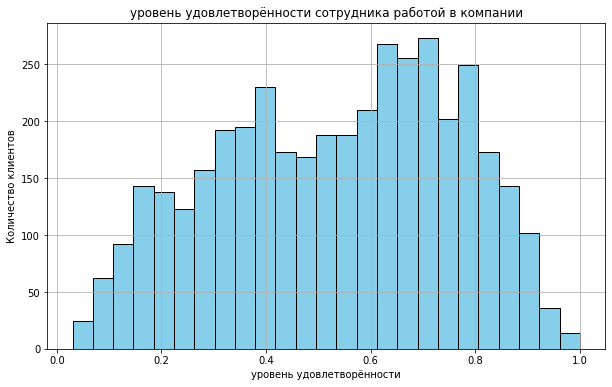

In [34]:
num_variable_visualization(train_job_satisfaction_rate, 'job_satisfaction_rate', 'уровень удовлетворённости сотрудника работой в компании', 'уровень удовлетворённости')

Наблюдается два основны пика в распределении целевого признака.

##### Изучим качественные признаки train_job_satisfaction_rate

К качественным признакам относятся:

- dept;
- level;
- workload;
- last_year_promo;
- last_year_violations.

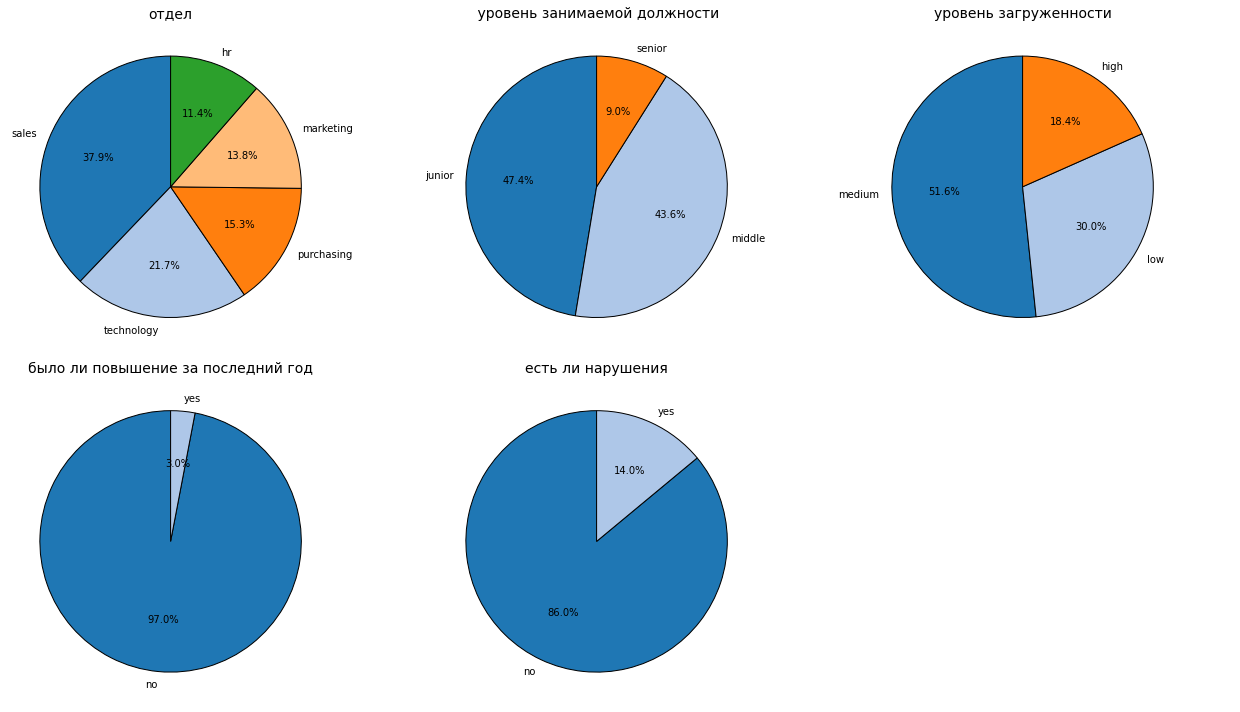

In [35]:
columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']  
titles = ['отдел', ' уровень занимаемой должности', 'уровень загруженности', 'было ли повышение за последний год', 
          'есть ли нарушения']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  

axes = axes.flatten()

for i, ax in enumerate(axes[:len(columns)]): 
    cat_variable_visualization(train_job_satisfaction_rate, columns[i], titles[i], ax)

for ax in axes[len(columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Наибольшее число сотрудников работает в отделе продаж (38%), в компании работает всего 9% senior, junior и middle распределены практически одинково. Преобладает средний уровень загруженности. Всего у 3% было повышение за прошедший год, у 14% были нарушения. 

##### Корреляционный анализ тренировочной выборки

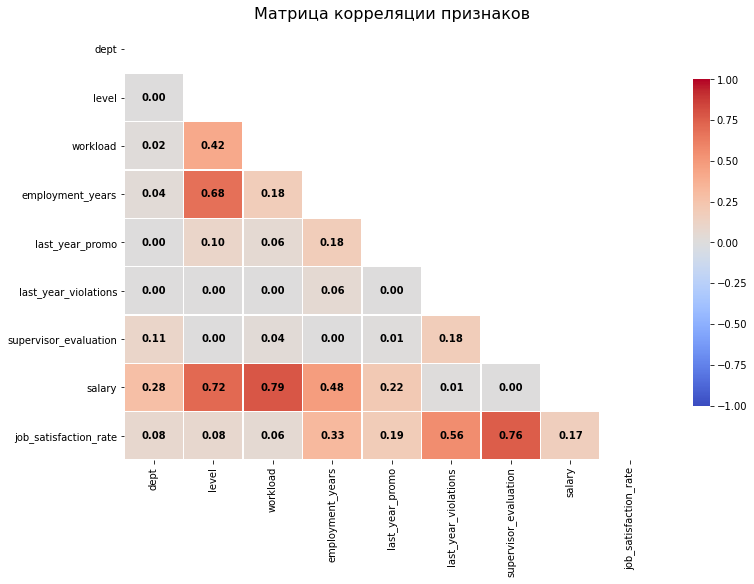

In [36]:
interval_cols = [
    'salary',
    'job_satisfaction_rate'
]

phik_matrix = train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix,
    annot=True,          
    fmt=".2f",           
    cmap="coolwarm",     
    mask=mask,          
    linewidths=0.5,     
    cbar_kws={"shrink": 0.75},  
    vmin=-1, vmax=1,     
    annot_kws={"size": 10, "weight": "bold", "color": "black"}  
)

plt.title("Матрица корреляции признаков", fontsize=16)
plt.show()

С целевым признаком коррелируют:
- supervisor_evaluation - сильная положительная связь (0.76) (повышение сильно положительно влияют на сотрудника);
- last_year_violations - умеренная положительная связь (0.56) (полученные замечания за нарушения трудового договора негативно влияют на удовлетворенность);
- employment_years - слабая положительная связь (0.33).


Мультиколлинеарность отсутствует, но не будем удалять слабокоррелирующие признаки, они могут быть важны для принятия решений модели.

##### Изучим количественные признаки test_features

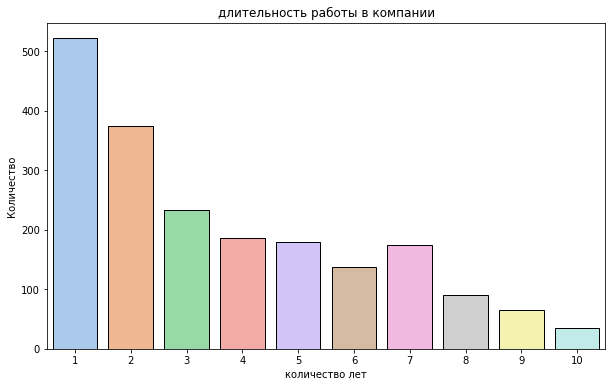

In [37]:
num_variable_visualization(test_features, 'employment_years', 'длительность работы в компании', 'количество лет')

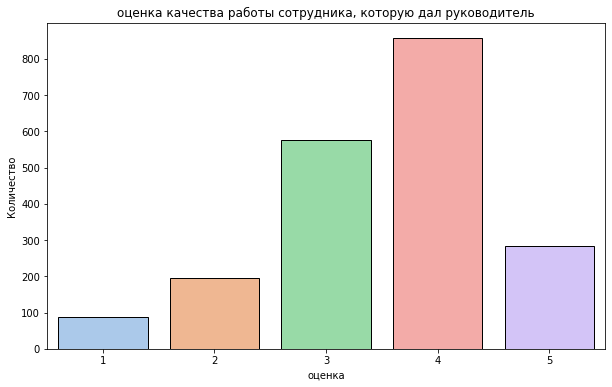

In [38]:
num_variable_visualization(test_features, 'supervisor_evaluation', 'оценка качества работы сотрудника, которую дал руководитель', 'оценка')

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


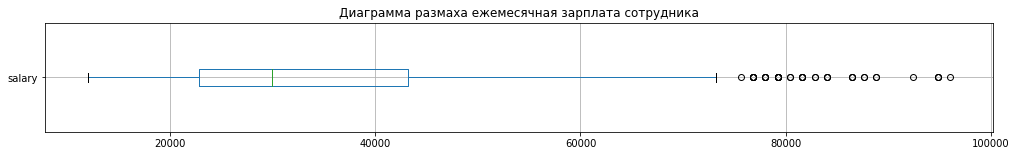

In [39]:
num_variable_analysis(test_features, 'salary', 'ежемесячная зарплата сотрудника')

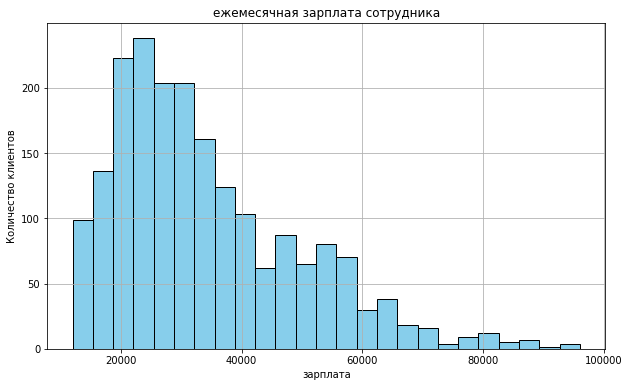

In [40]:
num_variable_visualization(test_features, 'salary', 'ежемесячная зарплата сотрудника', 'зарплата')

Распределение количественных признаков в тестовой выборки похоже на распределение в тренировочной.

##### Изучим качественные признаки test_features

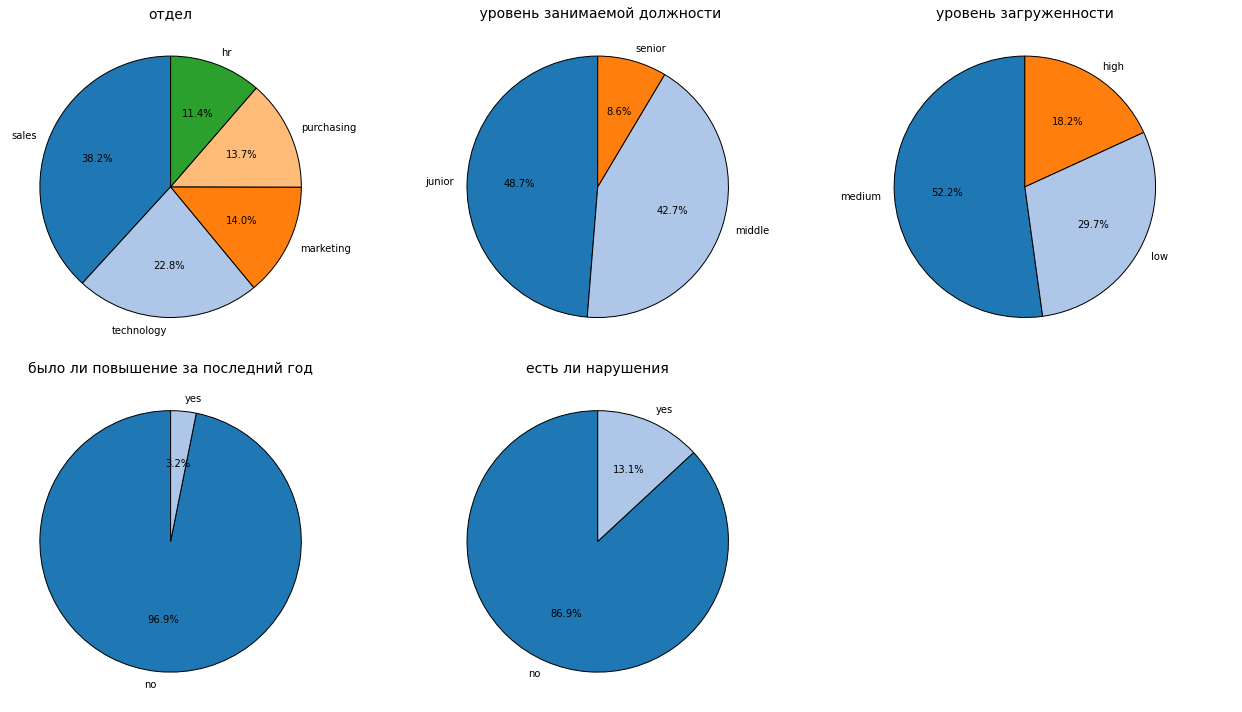

In [41]:
columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']  
titles = ['отдел', ' уровень занимаемой должности', 'уровень загруженности', 'было ли повышение за последний год', 
          'есть ли нарушения']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  

axes = axes.flatten()

for i, ax in enumerate(axes[:len(columns)]): 
    cat_variable_visualization(test_features, columns[i], titles[i], ax)

for ax in axes[len(columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Распределение качественных признаков в тестовой выборки похоже на распределение в тренировочной.

##### Корреляционный анализ тестовой выборки

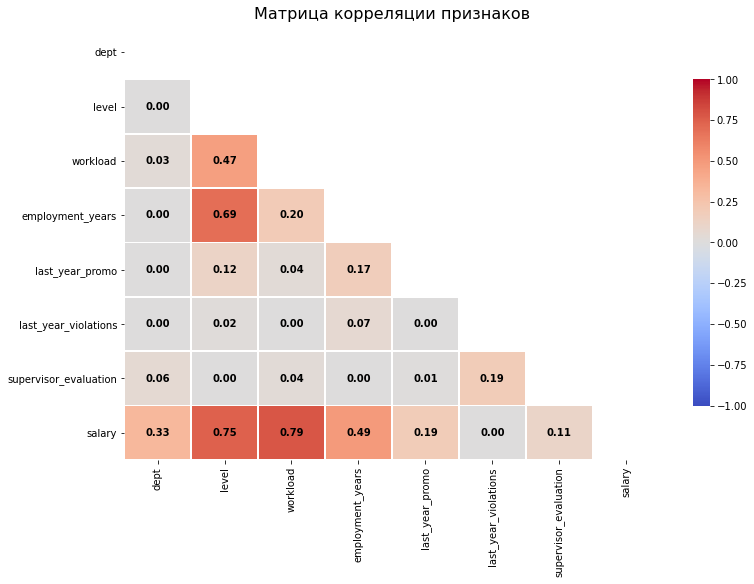

In [42]:
interval_cols = [
    'salary',
]

phik_matrix = test_features.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix,
    annot=True,          
    fmt=".2f",           
    cmap="coolwarm",     
    mask=mask,          
    linewidths=0.5,     
    cbar_kws={"shrink": 0.75},  
    vmin=-1, vmax=1,     
    annot_kws={"size": 10, "weight": "bold", "color": "black"}  
)

plt.title("Матрица корреляции признаков", fontsize=16)
plt.show()

При анализе тренировочной выборки особых изменений замечено не было.

По исследовательскому анализу можно сделать следующие выводы:

- наибольшее количестов сотрудников работает 1 год в компании, опытных сотрудников намного меньше, наблюдается дисбаланс классов;
- в основном преобладают оценки 3 и 4;
- средняя зарплата составляет 33926, наблюдается значительный разброс, в дальнейшем потребуется применить масштабирование;
- в распределении целевого признака наблюдается два основны пика;
- наибольшее число сотрудников работает в отделе продаж (38%);
- в компании работает всего 9% senior, junior и middle распределены практически одинково;
- преобладает средний уровень загруженности; 
- всего у 3% было повышение за прошедший год, у 14% были нарушения.

Для признаков `level` и `workload` применим OrdinalEncoder.

С целевым признаком коррелируют:

supervisor_evaluation - сильная положительная связь (0.76) (повышение сильно положительно влияют на сотрудника);
last_year_violations - умеренная положительная связь (0.56) (полученные замечания за нарушения трудового договора негативно влияют на удовлетворенность);
employment_years - слабая положительная связь (0.33).

Мультиколлинеарность отсутствует. При анализе тренировочной выборки особых изменений замечено не было.

### Шаг 4. Подготовка данных

In [43]:
X_train = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

test_features = test_features.sort_values(by='id').reset_index(drop=True)
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.sort_values(by='id').reset_index(drop=True)

X_test = test_features.drop('id', axis=1)
y_test = test_target_job_satisfaction_rate['job_satisfaction_rate']

print(f'Количестов дубликатов X_train: {X_train.duplicated().sum()}')
print(f'Количестов дубликатов X_test: {X_test.duplicated().sum()}')

X_train.drop_duplicates(inplace=True, ignore_index=False)
y_train = y_train[y_train.index.isin(X_train.index)]

X_test.drop_duplicates(inplace=True, ignore_index=False)
y_test = y_test[y_test.index.isin(X_test.index)]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Количестов дубликатов X_train: 1492
Количестов дубликатов X_test: 557
(2508, 8)
(2508,)
(1443, 8)
(1443,)


In [44]:
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000
3,technology,junior,low,4,no,no,2,18000
4,hr,junior,medium,1,no,no,3,22800


In [45]:
y_train.head()

0    0.58
1    0.76
2    0.11
3    0.37
4    0.20
Name: job_satisfaction_rate, dtype: float64

In [46]:
# создаём списки с названиями признаков
ohe_columns = [ 'dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']
               
# создаём пайплайн для подготовки признаков из списка ohe_columns: OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([ 
    ('preprocessor', data_preprocessor),  
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE)) 
])

In [47]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 25),
        'models__min_samples_split': range(2, 25),
        'models__max_features': range(2, 25),  
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
    ,
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False]
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'models__weights': ['uniform', 'distance'],
        'models__p': [1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

### Шаг 5. Обучение моделей

##### Функция метрики SMAPE

In [48]:
def smape(y_true, y_pred):
       return (100 / len(y_true)) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    
smape_score = make_scorer(smape, greater_is_better=False)

#####  Поиск лучшей модели

In [49]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=KFold(n_splits=5),
    n_iter=30,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [50]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 5),
                                         'models__p': [1, 2],
                                         'models__weights': ['uniform',
                                                             'distance'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [51]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_params_) 

Лучшая модель и её параметры:

 {'preprocessor__num': 'passthrough', 'models__min_samples_split': 9, 'models__min_samples_leaf': 4, 'models__max_features': 11, 'models__max_depth': 20, 'models': DecisionTreeRegressor(random_state=42)}


In [52]:
print('Метрика SMAPE для лучшей модели:\n', randomized_search.best_score_*(-1)) 

Метрика SMAPE для лучшей модели:
 18.149242900918544


In [53]:
best_model = randomized_search.best_estimator_
print('Метрика SMAPE на тестовой выборке:', smape(y_test, best_model.predict(X_test)))

Метрика SMAPE на тестовой выборке: 14.991053843194686


In [54]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

dummy_predictions = dummy_clf.predict(X_test)

dummy_smapes = smape(y_test, dummy_predictions)
print(f'Метрика SMAPE  для DummyClassifier: {dummy_smapes}')

Метрика SMAPE  для DummyClassifier: 40.30894704046167


**Лучшей моделью оказалась DecisionTreeRegressor со следующими параметрами: 'passthrough', 'models__min_samples_split': 9, 'models__min_samples_leaf': 4, 'models__max_features': 11, 'models__max_depth': 20**

**На тестовых данных метрика достигла 14.795, а на тренировочных 18.068.**

##### Анализ важности признаков

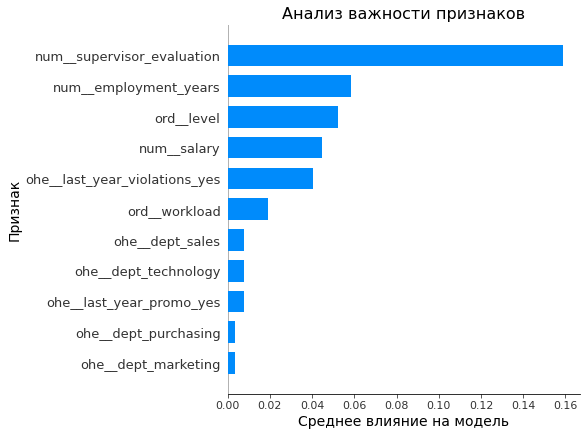

In [55]:
X_train_encoded = randomized_search.best_estimator_['preprocessor'].transform(X_train)
model_best = randomized_search.best_estimator_['models']
explainer = shap.Explainer(model_best, X_train_encoded)
shap_values = explainer(X_train_encoded)

labels = randomized_search.best_estimator_['preprocessor'].get_feature_names_out()

shap.summary_plot(shap_values, features=X_train_encoded, feature_names=labels, plot_type='bar', show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_title('Анализ важности признаков', fontsize=16)
ax.set_xlabel('Среднее влияние на модель', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

plt.show()

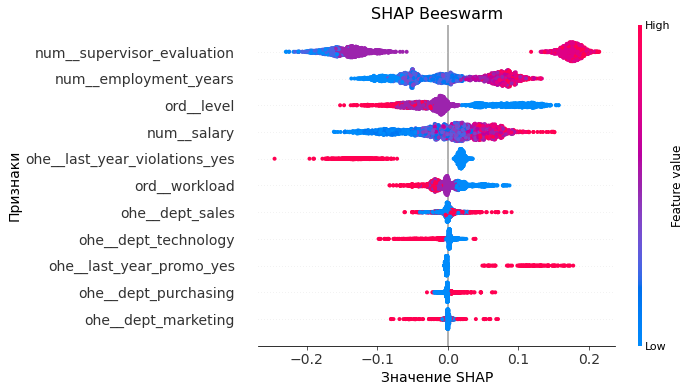

In [56]:
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=labels)
explainer = shap.Explainer(model_best, X_train_encoded_df)
shap_values = explainer(X_train_encoded_df)

shap.plots.beeswarm(shap_values, max_display=16, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_title('SHAP Beeswarm', fontsize=16)
ax.set_xlabel('Значение SHAP', fontsize=14)
ax.set_ylabel('Признаки', fontsize=14)
ax.tick_params(labelsize=14)

plt.show()

Самый важный признак:supervisor_evaluation.

    
Другие значимые признаки: employment_years, level, last_year_violations_yes salary.

    
Признаки supervisor_evaluation и employment_years — ключевые для предсказания.
Влияние salary сложное. Категориальные признаки (департаменты) оказывают слабое влияние.

### Шаг 6. Оформление выводов по первой задаче

Была создана метрика SMAPE («симметричное среднее абсолютное процентное отклонение»). В анализе учавствовало 4 модели. Были перебраны их гиперпараметры. Лучше всего себя показал DecisionTreeRegressor. На тестовых данных метрика достигла 14.795, а на тренировочных 18.068.

## Задача №2 (предсказание увольнения сотрудника из компании)

### Шаг 1. Загрузка данных

##### Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним его в датафрейм

In [57]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

##### Изучим информацию о датафреймах

In [58]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [59]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [60]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [61]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [62]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [63]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**Типы данных соответствуют действительности, есть пропуски в test_features (в `dept` и в `level`).**

### Шаг 2. Предобработка данных.

##### Проверим на наличие пропусков и дубликатов

In [64]:
skips_dulicates(train_quit);

Пропусков нет.
Дубликатов нет.


In [65]:
skips_dulicates(test_features);

Пропуски найдены, общее количество пропусков: 3
Пропуски по столбцам:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
Дубликатов нет.


In [66]:
skips_dulicates(test_target_quit);

Пропусков нет.
Дубликатов нет.


Явныйх дубликтов обнаружено не было, проверим неявные.

In [67]:
unique_values(train_quit)

{'dept': array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
       dtype=object),
 'level': array(['middle', 'junior', 'sinior'], dtype=object),
 'workload': array(['high', 'medium', 'low'], dtype=object),
 'last_year_promo': array(['no', 'yes'], dtype=object),
 'last_year_violations': array(['no', 'yes'], dtype=object),
 'quit': array(['no', 'yes'], dtype=object)}

In [68]:
train_quit['level'] = train_quit['level'].replace({'sinior': 'senior'})

In [69]:
unique_values(test_features)

{'dept': array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
       dtype=object),
 'level': array(['junior', 'middle', 'sinior', nan], dtype=object),
 'workload': array(['medium', 'low', 'high', ' '], dtype=object),
 'last_year_promo': array(['no', 'yes'], dtype=object),
 'last_year_violations': array(['no', 'yes'], dtype=object)}

In [70]:
test_features['dept'] = test_features['dept'].replace({' ': np.nan})
test_features['workload'] = test_features['workload'].replace({' ': np.nan})
test_features['level'] = test_features['level'].replace({'sinior': 'senior'})

In [71]:
train_quit['quit'].unique()

array(['no', 'yes'], dtype=object)

### Шаг 3. Исследовательский анализ данных

##### Изучим количественные признаки train_quit

В train_quit количественными признакими являются:

- employment_years;
- supervisor_evaluation;
- salary.

In [73]:
train_quit['employment_years'].unique()

array([ 2,  5,  1,  8,  4,  7,  3,  9,  6, 10])

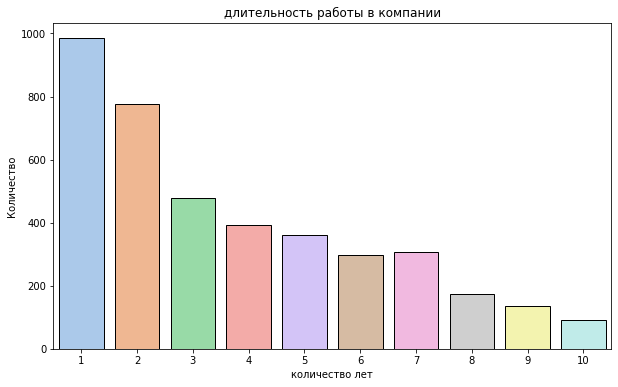

In [74]:
num_variable_visualization(train_quit, 'employment_years', 'длительность работы в компании', 'количество лет')

Преобладают работники, которые проработали меньше 4 лет, больше всего 1 год.

In [75]:
train_quit['supervisor_evaluation'].unique()

array([4, 1, 3, 5, 2])

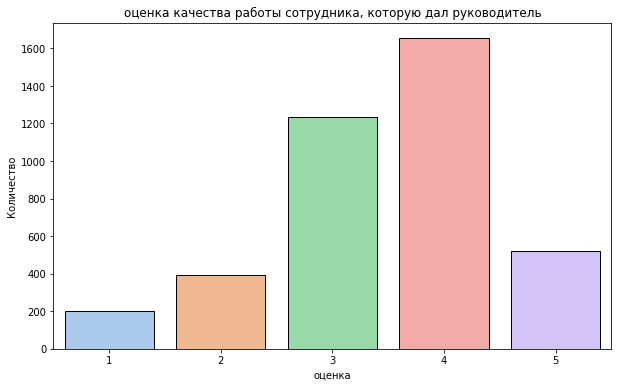

In [76]:
num_variable_visualization(train_quit, 'supervisor_evaluation', 'оценка качества работы сотрудника, которую дал руководитель', 'оценка')

Преобладают оценки 3 и 4.

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


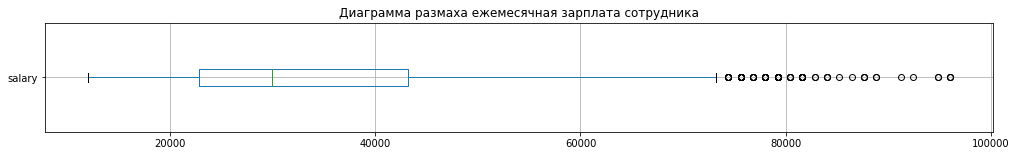

In [77]:
num_variable_analysis(train_quit, 'salary', 'ежемесячная зарплата сотрудника')

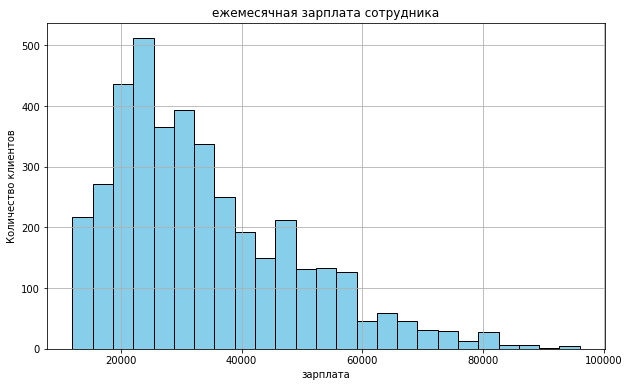

In [78]:
num_variable_visualization(train_quit, 'salary', 'ежемесячная зарплата сотрудника', 'зарплата')

Гистограмма смещена влево, присутствует значительный разброс.

##### Изучим качественные признаки train_quit

К качественным признакам относятся:

- dept;
- level;
- workload;
- last_year_promo;
- last_year_violations;
- quit.

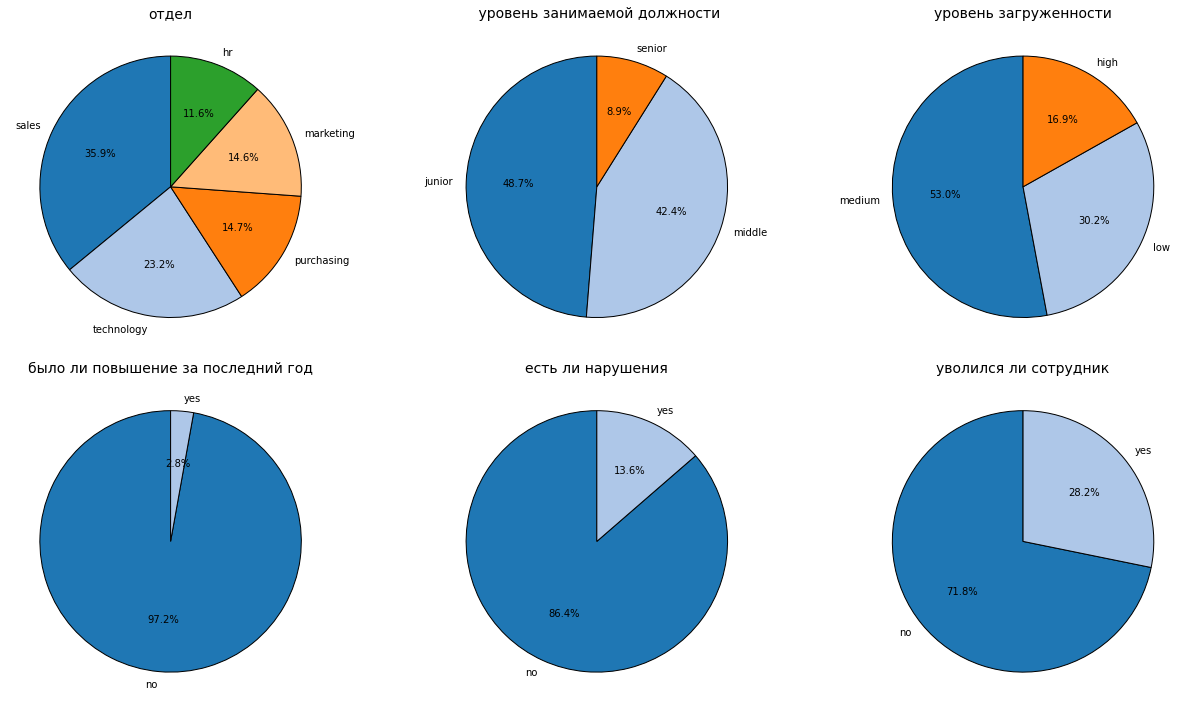

In [79]:
columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']  
titles = ['отдел', ' уровень занимаемой должности', 'уровень загруженности', 'было ли повышение за последний год', 
          'есть ли нарушения', 'уволился ли сотрудник']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  

axes = axes.flatten()

for i, ax in enumerate(axes[:len(columns)]): 
    cat_variable_visualization(train_quit, columns[i], titles[i], ax)

for ax in axes[len(columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Распределение признаков очень похоже на первую задачу. Около 30% сотрудников уволилось.

##### Корреляционный анализ тренировочной выборки

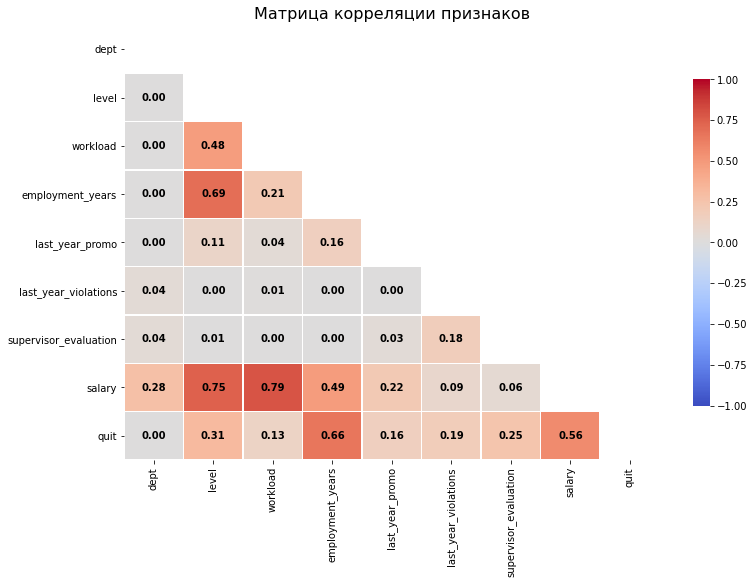

In [80]:
interval_cols = [
    'salary',
]

phik_matrix = train_quit.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix,
    annot=True,          
    fmt=".2f",           
    cmap="coolwarm",     
    mask=mask,          
    linewidths=0.5,     
    cbar_kws={"shrink": 0.75},  
    vmin=-1, vmax=1,     
    annot_kws={"size": 10, "weight": "bold", "color": "black"}  
)

plt.title("Матрица корреляции признаков", fontsize=16)
plt.show()

С целевым признаком коррелируют:

- employment_years - сильная положительная связь (0.66);
- salary - умеренная положительная связь (0.56);
- level - слабая положительная связь (0.31).

Мультиколлинеарность отсутствует.

##### Составление портрета уволившегося сотрудника

In [81]:
quit_employees = train_quit[train_quit['quit'] == 'yes']

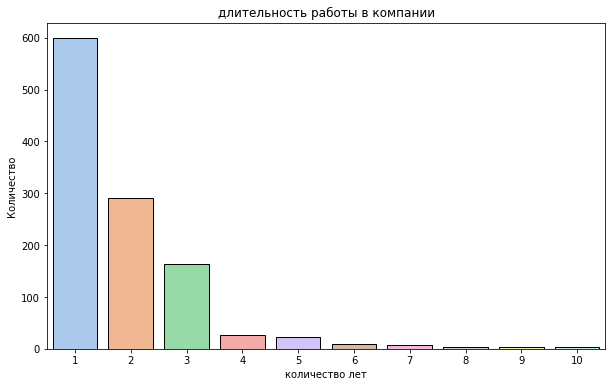

In [82]:
num_variable_visualization(quit_employees, 'employment_years', 'длительность работы в компании', 'количество лет')

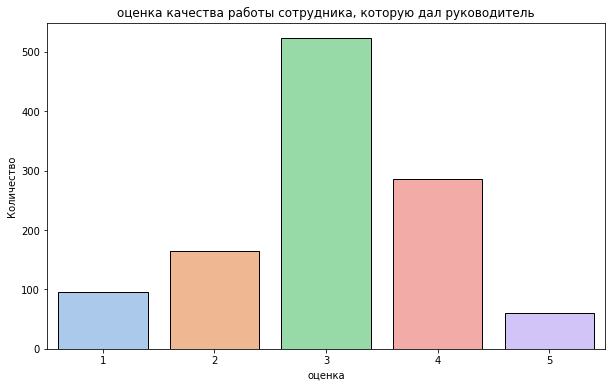

In [83]:
num_variable_visualization(quit_employees, 'supervisor_evaluation', 'оценка качества работы сотрудника, которую дал руководитель', 'оценка')

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64


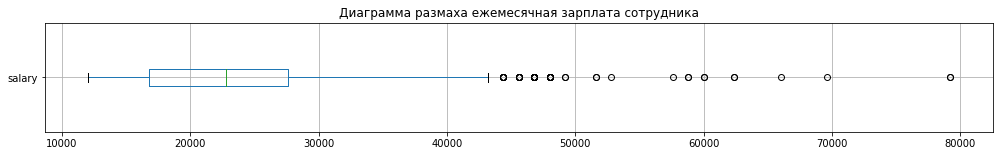

In [84]:
num_variable_analysis(quit_employees, 'salary', 'ежемесячная зарплата сотрудника')

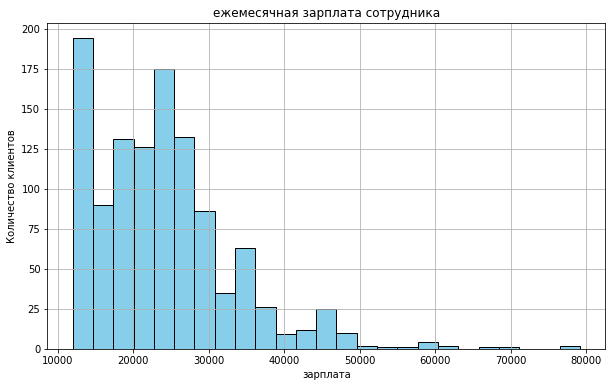

In [85]:
num_variable_visualization(quit_employees, 'salary', 'ежемесячная зарплата сотрудника', 'зарплата')

Портрет уволившегося сотрудника:в основном увольняются сотрудники, проработавшие менее 4 лет, больше всего уходя после 1 года. Они получают оценку 3, средняя зарплата у таких сторудников ниже - 23885, хотя иногда увольняются и с большой зарплатой, но в больщинстве с зарплатой до 30000.

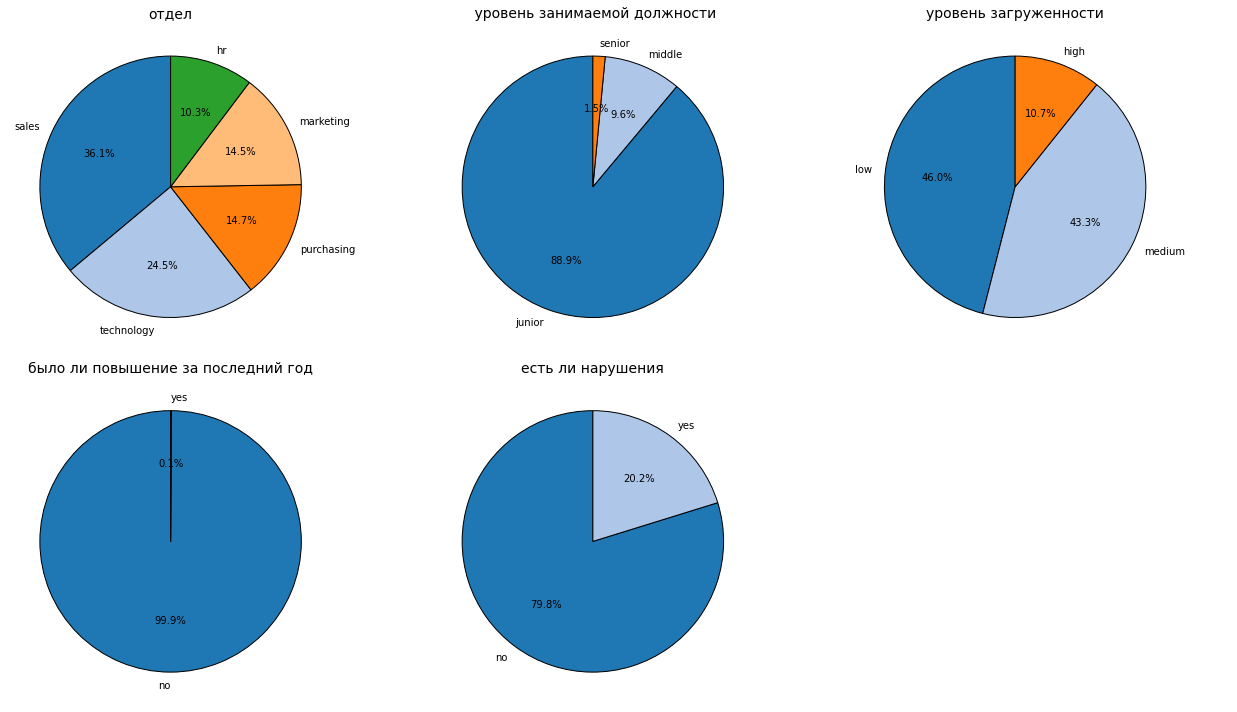

In [86]:
columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']  
titles = ['отдел', ' уровень занимаемой должности', 'уровень загруженности', 'было ли повышение за последний год', 
          'есть ли нарушения']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  

axes = axes.flatten()

for i, ax in enumerate(axes[:len(columns)]): 
    cat_variable_visualization(quit_employees, columns[i], titles[i], ax)

for ax in axes[len(columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Бошльше всего уволилось из отдела продаж, 88.9% уволившихся занимали должность junior. Уровень загруженности в основном был низкий или средний, всего 10.7% составляла высокая загруженность. Практически у 100% из них не было повышения, у 20% были замечены нарушения.

##### Проверим, влият ли уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник

In [87]:
df = test_target_job_satisfaction_rate.merge(test_target_quit, on='id')
df_quit=df[df['quit'] == 'yes']
df_stay=df[df['quit'] == 'no']

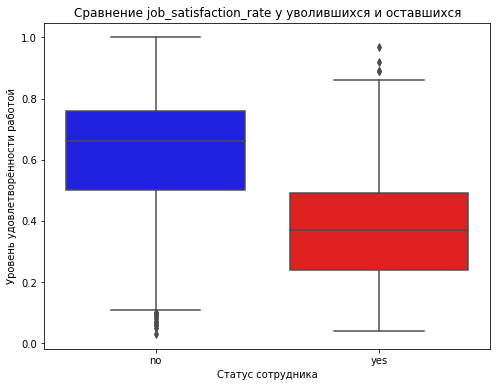

In [88]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['quit'], y=df['job_satisfaction_rate'], palette={'yes': 'red', 'no': 'blue'})

plt.xlabel('Статус сотрудника')
plt.ylabel('Уровень удовлетворённости работой')
plt.title('Сравнение job_satisfaction_rate у уволившихся и оставшихся')
plt.show()

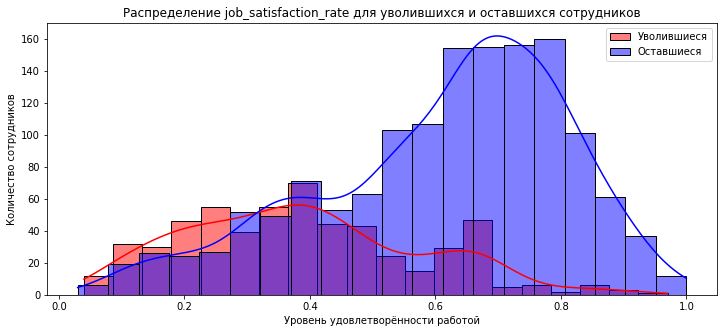

In [89]:
plt.figure(figsize=(12, 5))

sns.histplot(df_quit['job_satisfaction_rate'], color='red', label='Уволившиеся', kde=True, bins=20, alpha=0.5)
sns.histplot(df_stay['job_satisfaction_rate'], color='blue', label='Оставшиеся', kde=True, bins=20, alpha=0.5)

plt.xlabel('Уровень удовлетворённости работой')
plt.ylabel('Количество сотрудников')
plt.title('Распределение job_satisfaction_rate для уволившихся и оставшихся сотрудников')
plt.legend()
plt.show()

Уволившиеся сотрудники в среднем имеют более низкий уровень удовлетворённости работой по сравнению с оставшимися.

Разброс уволившихся шире (есть небольшое количество людей, которые были полностью удовлетворены работой, но ушли). У оставшихся сотрудников уровень удовлетворённости в среднем выше и более сконцентрирован в диапазоне 0.6–0.9.

Можно сказать, что удовлетворённость работой действительно связана с увольнением:

- люди с низкой удовлетворённостью чаще увольняются;
- оставшиеся в компаниии в основном имеют высокий уровень удовлетворённости.

По исследовательскому анализу можно сделать следующие выводы:

- распределение признаков очень похоже на первую задачу;
- присутствует дисбаланс целевого признака (71.8% не уволились);

С целевым признаком коррелируют:

- employment_years - сильная положительная связь (0.66);
- salary - умеренная положительная связь (0.56);
- level - слабая положительная связь (0.31).

Портрет уволившегося сотрудника: в основном увольняются сотрудники, проработавшие менее 4 лет, больше всего уходя после 1 года. Они получают оценку 3, средняя зарплата у таких сотрудников ниже - 23885, хотя иногда увольняются и с большой зарплатой, но в большинстве с зарплатой до 30000. Больше всего уволилось из отдела продаж, 88.9% уволившихся занимали должность junior. Уровень загруженности в основном был низкий или средний, всего 10.7% составляла высокая загруженность. Практически у 100% из них не было повышения, у 20% были замечены нарушения.

Можно сказать, что удовлетворённость работой действительно связана с увольнением:

- люди с низкой удовлетворённостью чаще увольняются;
- оставшиеся в компании в основном имеют высокий уровень удовлетворённости.

### Шаг 4. Добавление нового входного признака

In [90]:
train_quit['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(train_quit)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.628333
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.825000
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.332500
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.348750
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.806667


In [91]:
test_features['job_satisfaction_rate'] = best_model.predict(test_features)
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.888000
1,686555,hr,junior,medium,1,no,no,4,30000,0.668750
2,467458,sales,middle,low,5,no,no,4,19200,0.668333
3,418655,sales,middle,low,6,no,no,4,19200,0.668333
4,789145,hr,middle,medium,5,no,no,5,40800,0.853750


#### Подготовка данных

In [92]:
all_features = test_target_quit.merge(test_features, on='id')

train = train_quit.drop(['id'], axis=1)
train.drop_duplicates(inplace=True)
test = all_features.drop(['quit','id'], axis=1)
target = all_features['quit'] 


X_train = train.drop('quit', axis=1)
y_train = train['quit']

X_test = test
y_test = target

In [93]:
num_columns.append('job_satisfaction_rate')

pipe_final_2 = Pipeline([ 
    ('preprocessor', data_preprocessor),  
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('models', LogisticRegression(random_state=RANDOM_STATE)) 
])

In [94]:
param_grid_2 = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'models__weights': ['uniform', 'distance'],
        'models__p': [1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='liblinear')],
        'models__C': range(1, 10),  
        'models__penalty': ['l1', 'l2'],

        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
]

### Шаг 6. Обучение модели

#####  Поиск лучшей модели

In [95]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=10,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=100,
    n_jobs=-1
)

In [96]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [97]:
randomized_search_2.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pi...
                                         'models__weights': ['uniform',
                                                             'distance'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 10),
                                         'models__penalty': ['l1', 'l2'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [98]:
print("Лучшая модель и её параметры:\n", randomized_search_2.best_params_)
print("Метрика ROC-AUC для лучшей модели:\n", randomized_search_2.best_score_)
print("Метрика ROC-AUC на тестовой выборке:", randomized_search_2.score(X_test, y_test))

Лучшая модель и её параметры:
 {'preprocessor__num': MinMaxScaler(), 'models__penalty': 'l1', 'models__C': 1, 'models': LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')}
Метрика ROC-AUC для лучшей модели:
 0.9116198100459091
Метрика ROC-AUC на тестовой выборке: 0.9133440506529169


In [99]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

dummy_predictions = dummy_clf.predict_proba(X_test)

dummy_roc = roc_auc_score(y_test, dummy_predictions[:, 1])  
print(f'Метрика roc_auc для DummyClassifier: {dummy_roc}')

Метрика roc_auc для DummyClassifier: 0.5


### Анализ важности признаков

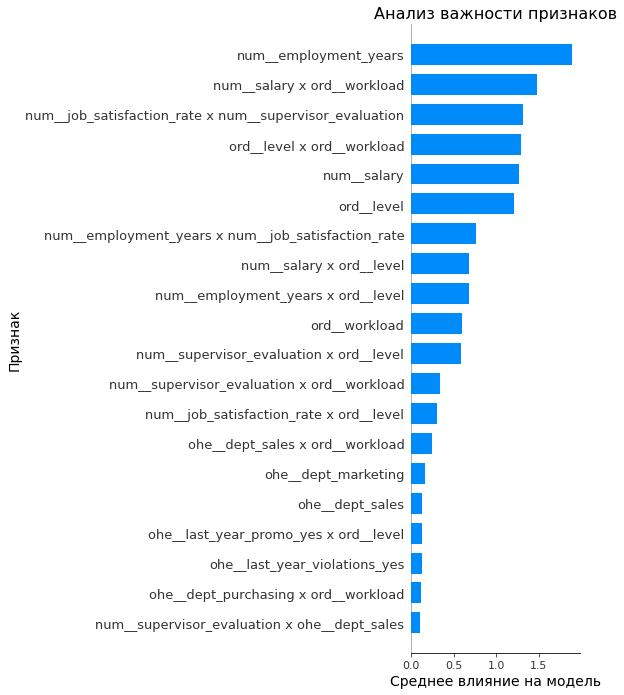

In [100]:
X_train_encoded = randomized_search_2.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_train_poly = randomized_search_2.best_estimator_.named_steps['poly'].transform(X_train_encoded)

model_best = randomized_search_2.best_estimator_.named_steps['models']

explainer = shap.Explainer(model_best, X_train_poly)
shap_values = explainer(X_train_poly)

feature_names = randomized_search_2.best_estimator_.named_steps['poly'].get_feature_names_out(
    randomized_search_2.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
)


simple_feature_names = []
for name in feature_names:
    if ' ' in name:
        simple_name = ' x '.join(sorted(name.split(' ')))
    else:
        simple_name = name
    simple_feature_names.append(simple_name)


shap.summary_plot(shap_values, features=X_train_poly, feature_names=simple_feature_names, plot_type='bar', show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_title('Анализ важности признаков', fontsize=16)
ax.set_xlabel('Среднее влияние на модель', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

plt.show()

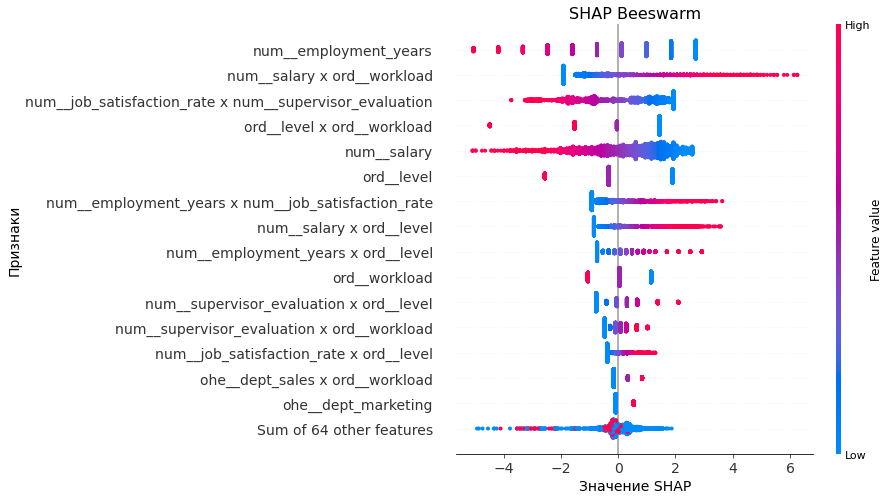

In [101]:
X_train_encoded_df = pd.DataFrame(X_train_poly, columns=simple_feature_names)

explainer = shap.Explainer(model_best, X_train_encoded_df)
shap_values = explainer(X_train_encoded_df)

shap.plots.beeswarm(shap_values, max_display=16, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_title('SHAP Beeswarm', fontsize=16)
ax.set_xlabel('Значение SHAP', fontsize=14)
ax.set_ylabel('Признаки', fontsize=14)
ax.tick_params(labelsize=14)

plt.show()

Наибольшее влияние на целевую переменную оказывают:

- employment_years;
- salary x ord_workload (взаимодействие между зарплатой и уровнем рабочей нагрузки также значительно влияет на модель);
- job_satisfaction_rate x supervisor_evaluation

Полиномиальные признаки имеют сильное влияние. Многие из наиболее важных признаков являются взаимодействиями между различными переменными. Это указывает на то, что взаимодействия между различными аспектами работы сотрудника (например, зарплата и рабочая нагрузка) играют ключевую роль в модели.

### Шаг 6. Оформление выводов по первой задаче

В анализе учавствовало 3 модели. Были перебраны их гиперпараметры. Лучше всего себя показала LogisticRegression. 

Лучшая модель и её параметры:
 {'preprocessor__num': MinMaxScaler(), 'models__penalty': 'l1', 'models__C': 1, 'models': LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')}
Метрика ROC-AUC для лучшей модели:
 0.9117447685053582
Метрика ROC-AUC на тестовой выборке: 0.913366275509196

## Общий вывод

**Описание задачи**

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Задачи:

- Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика;
- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


**Для выполнения первой задачи потребуется**:

- изучить общую информацию о данных;
- произвести предобработку данных;
- выполнить исследовательский анализ данных;
- подготовить признаки в пайплайне;
- обучить модели;

Для этой задачи заказчик предоставил данные с признаками:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.
- Тренировочная выборка: train_job_satisfaction_rate.csv

Входные признаки тестовой выборки: test_features.csv

Целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv

В ходе предобработки данные были проверены на пропуски и дубликаты, которые были устранены. 

Во время исследовательского анализа были изучены количественные и качетсвенные признаки, произведен корреляционные анализ. 

По исследовательскому анализу можно сделать следующие выводы:

- наибольшее количество сотрудников работает 1 год в компании, опытных сотрудников намного меньше, наблюдается дисбаланс классов;
- в основном преобладают оценки 3 и 4;
- средняя зарплата составляет 33926, наблюдается значительный разброс;
- в распределении целевого признака наблюдается два основны пика;
- наибольшее число сотрудников работает в отделе продаж (38%);
- в компании работает всего 9% senior, junior и middle распределены практически одинково;
- преобладает средний уровень загруженности;
- всего у 3% было повышение за прошедший год, у 14% были нарушения.


С целевым признаком коррелируют:

- supervisor_evaluation - сильная положительная связь (0.76) (повышение сильно положительно влияют на сотрудника); 
- last_year_violations - умеренная положительная связь (0.56) (полученные замечания за нарушения трудового договора негативно влияют на удовлетворенность);
- employment_years - слабая положительная связь (0.33).

Мультиколлинеарность отсутствует. 

Далее был создан пайплайн, а также обчены модели, лучшая из которых: DecisionTreeRegressor со следующими параметрами: 'passthrough', 'models__min_samples_split': 9, 'models__min_samples_leaf': 4, 'models__max_features': 11, 'models__max_depth': 20. На тестовых данных метрика достигла 14.795, а на тренировочных 18.068.

Самый важный признак для этой модели:supervisor_evaluation.

Другие значимые признаки: employment_years, level, last_year_violations_yes, salary.

Признаки supervisor_evaluation и employment_years — ключевые для предсказания. Влияние salary сложное. Категориальные признаки (департаменты) оказывают слабое влияние.

Для выполнения второй задачи потребуется:

- изучить общую информацию о данных;
- произвести предобработку данных;
- выполнить исследовательский анализ данных;
- добавить новый входной признак;
- подготовить признаки в пайплайне;
- обучить модели;


Для второй задачи используются данные с признаками:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- quit — увольнение сотрудника из компании, целевой признак.


Тренировочная выборка: train_quit.csv

Входные признаки тестовой выборки те же, что и в прошлой задаче: test_features.csv

Целевой признак тестовой выборки: test_target_quit.csv

В ходе предобработки данные были проверены на пропуски и дубликаты, которые были устранены. 

Во время исследовательского анализа были изучены количественные и качетсвенные признаки, произведен корреляционные анализ, составлен портрет уволившегося сотрудника. 

По исследовательскому анализу можно сделать следующие выводы:
- распределение признаков очень похоже на первую задачу;
- присутствует дисбаланс целевого признака (71.8% не уволились);


С целевым признаком коррелируют:

- employment_years - сильная положительная связь (0.66);
- salary - умеренная положительная связь (0.56);
- level - слабая положительная связь (0.31).


Портрет уволившегося сотрудника: в основном увольняются сотрудники, проработавшие менее 4 лет, больше всего уходя после 1 года. Они получают оценку 3, средняя зарплата у таких сотрудников ниже - 23885, хотя иногда увольняются и с большой зарплатой, но в большинстве с зарплатой до 30000. Больше всего уволилось из отдела продаж, 88.9% уволившихся занимали должность junior. Уровень загруженности в основном был низкий или средний, всего 10.7% составляла высокая загруженность. Практически у 100% из них не было повышения, у 20% были замечены нарушения.

Можно сказать, что удовлетворённость работой действительно связана с увольнением:

- люди с низкой удовлетворённостью чаще увольняются;
- оставшиеся в компании в основном имеют высокий уровень удовлетворённости.

Так как удовлетворённость работой связана с увольнением был добавлен новый входной признак для данной задачи.

В анализе участвовало  3 модели. Были перебраны их гиперпараметры. Лучше всего себя показала LogisticRegression.

Лучшая модель и её параметры: {'preprocessor__num': MinMaxScaler(), 'models__penalty': 'l1', 'models__C': 1, 'models': LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')} Метрика ROC-AUC для лучшей модели: 0.9117447685053582 Метрика ROC-AUC на тестовой выборке: 0.913366275509196

Многие из наиболее важных признаков являются взаимодействиями между различными переменными. Это указывает на то, что взаимодействия между различными аспектами работы сотрудника (например, зарплата и рабочая нагрузка) играют ключевую роль в модели.

Рекомендации бизнесу:

Наблюдается большая текучка кадров (в основном в компании работают год или меньше), можно, например, попробовать улучшить корпоративную культуру, создать более благорприятные условия. Создать программы по вовлечению сотрудников (например, тимбилдинги, тренинги по личной эффективности или развитию лидерских качеств). Разработать менторскую программу для новых сотрудников, чтобы они быстрее адаптировались и чувствовали поддержку на всех этапах. На удовлетворенность сильно влияет оценка качества работы сотрудника, которую дал руководитель, преобладают 3 и 4, возможно нужно более мягко оценивать сотрудников, а также отправлять регулярно конструктивную обратную связь, поддерживать сотрудников в развитии. Удовлетворенность работой значительно влияет на то, уволится ли сотрудник или нет, стоит уделять этому большее внимание.